In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
import pandas as pd
import re

def annotate():
    for p in plt.gca().patches:
        height = p.get_height()
        plt.annotate(f'{height:.0f}' if p.get_height() != 0 else ' ', 
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='center', 
                     xytext=(0, 5), textcoords='offset points')

In [2]:
conn = sqlite3.connect("bmarket.db")
query = 'SELECT * FROM bank_marketing'
df = pd.read_sql_query(query,conn)
conn.close()

In [3]:
print("Number of duplicated rows:",df.duplicated().sum(),end="\n")
df.info()

Number of duplicated rows: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Client ID              41188 non-null  int64 
 1   Age                    41188 non-null  object
 2   Occupation             41188 non-null  object
 3   Marital Status         41188 non-null  object
 4   Education Level        41188 non-null  object
 5   Credit Default         41188 non-null  object
 6   Housing Loan           16399 non-null  object
 7   Personal Loan          37042 non-null  object
 8   Contact Method         41188 non-null  object
 9   Campaign Calls         41188 non-null  int64 
 10  Previous Contact Days  41188 non-null  int64 
 11  Subscription Status    41188 non-null  object
dtypes: int64(3), object(9)
memory usage: 3.8+ MB


In [4]:
df.sample(3)

,Client ID,Age,Occupation,Marital Status,Education Level,Credit Default,Housing Loan,Personal Loan,Contact Method,Campaign Calls,Previous Contact Days,Subscription Status
23556,3361,27 years,unemployed,married,basic.9y,no,None,no,Telephone,-14,999,no
7277,17480,34 years,blue-collar,single,high.school,no,None,no,cellular,2,999,no
24772,13074,26 years,blue-collar,married,basic.9y,unknown,None,no,Cell,2,999,no


In [5]:
df.drop(columns=['Client ID'],inplace=True)
df.describe().T
print('Total number of features:',len(df.columns))

Total number of features: 11


In [6]:
def convert_to_age(string:str):
    return int(re.search('\d+',string).group())

df['Age'] = df['Age'].map(convert_to_age)
df['Campaign Calls'] = df['Campaign Calls'].map(abs)

# Subscription Status

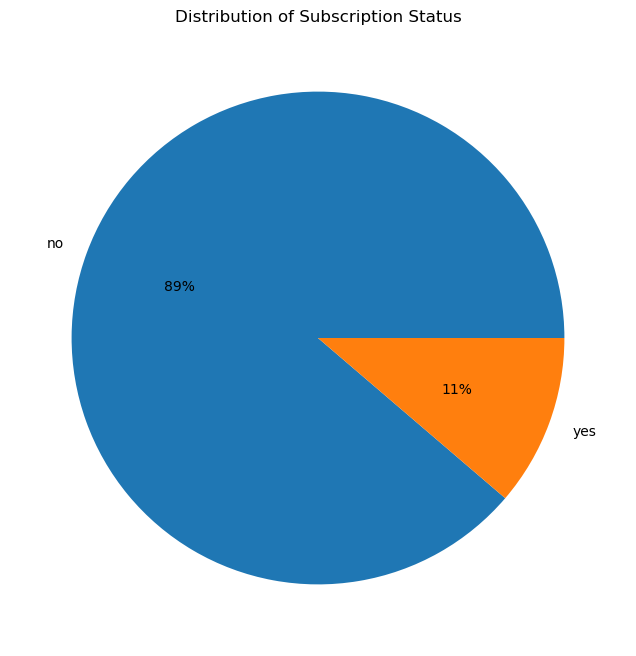

In [7]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Subscription Status')
plt.pie(df['Subscription Status'].value_counts().values,labels=df['Subscription Status'].value_counts().index,autopct='%.0f%%')
plt.show()

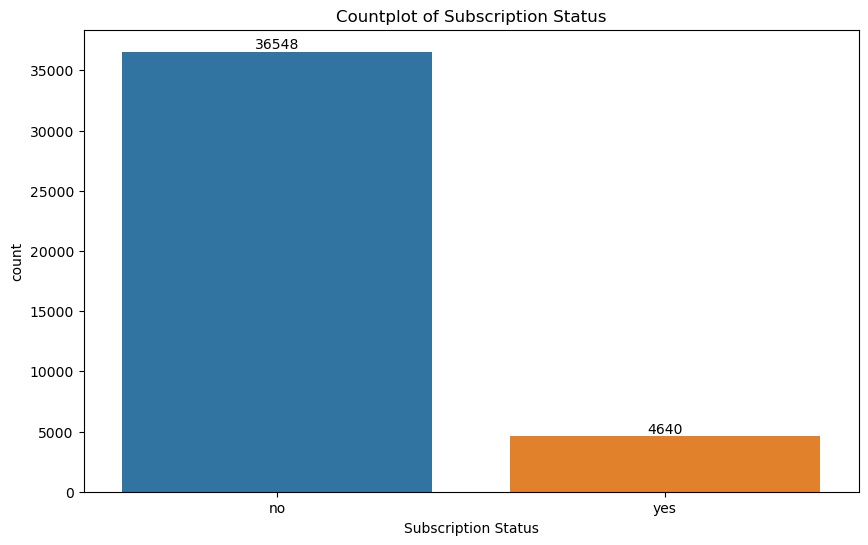

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Subscription Status',hue='Subscription Status')
plt.title('Countplot of Subscription Status')
annotate()

There is a class imbalance. The class of 'no' is over representated at 90% compared with the class of 'yes' at only 10%.

# Age

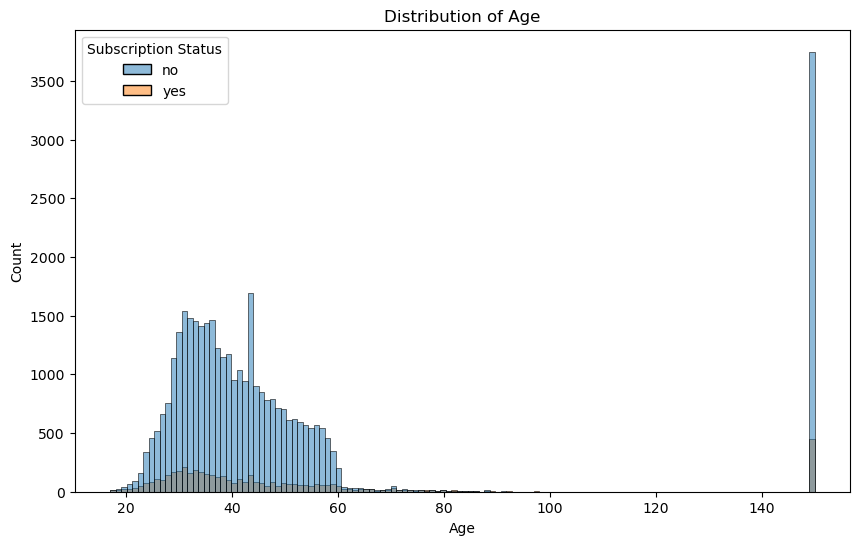

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(data=df,x='Age',hue='Subscription Status')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.show()

In [10]:
print("Total number of age outliers:",sum(df['Age']>100))
print(f"Percentage of age outliers: {100*sum(df['Age']>100)/df.shape[0]:.0f}%")

Total number of age outliers: 4197
Percentage of age outliers: 10%


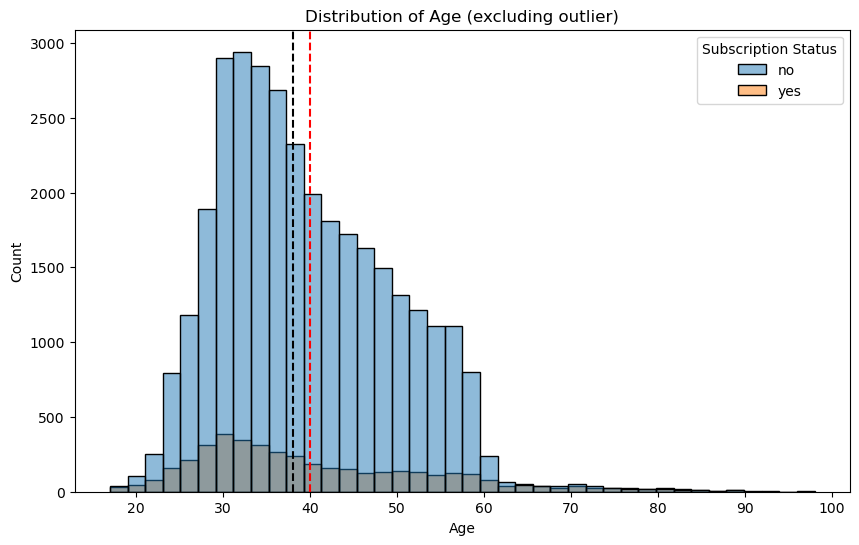

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(data=df[df['Age']<100],x='Age',hue='Subscription Status',bins=40)
plt.title('Distribution of Age (excluding outlier)')
plt.xlabel('Age')
plt.axvline(df[df['Age']<100]['Age'].mean(),c='r',ls='--',label='mean')
plt.axvline(df[df['Age']<100]['Age'].median(),c='k',ls='--',label='median')
plt.show()

In [12]:
pd.DataFrame(df['Age'].describe()).T

,count,mean,std,min,25%,50%,75%,max
Age,41188.0,51.231572,34.708486,17.0,33.0,40.0,51.0,150.0


Normal distribution observed for both classes. 
Note that the class imbalance is clearly reflected. 
Also, the distribution is slightly positively skewed (mean to the right of median). There is a sharp increase from ages 20 to 30 followed by a gentler decrease till 57 and then a sharp decrease at around age 60 onwards.

# Occupation

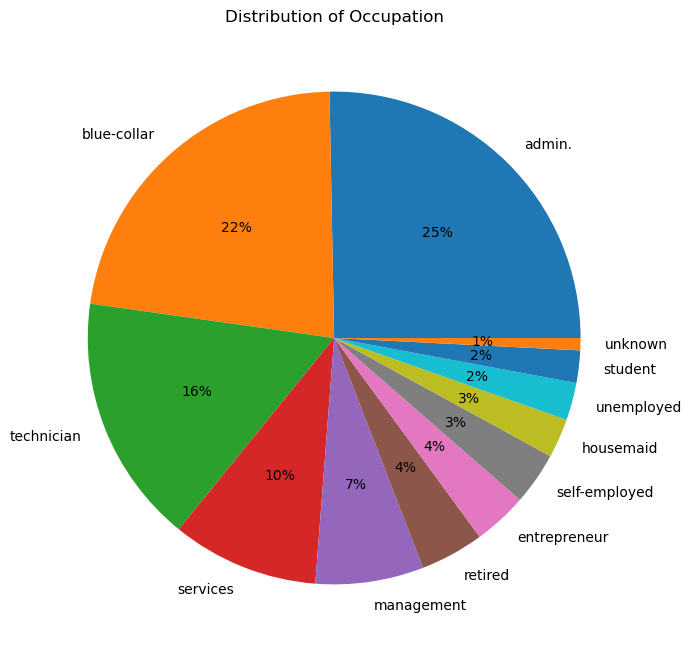

In [13]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Occupation')
plt.pie(df['Occupation'].value_counts().values,labels=df['Occupation'].value_counts().index,autopct='%.0f%%')
plt.show()

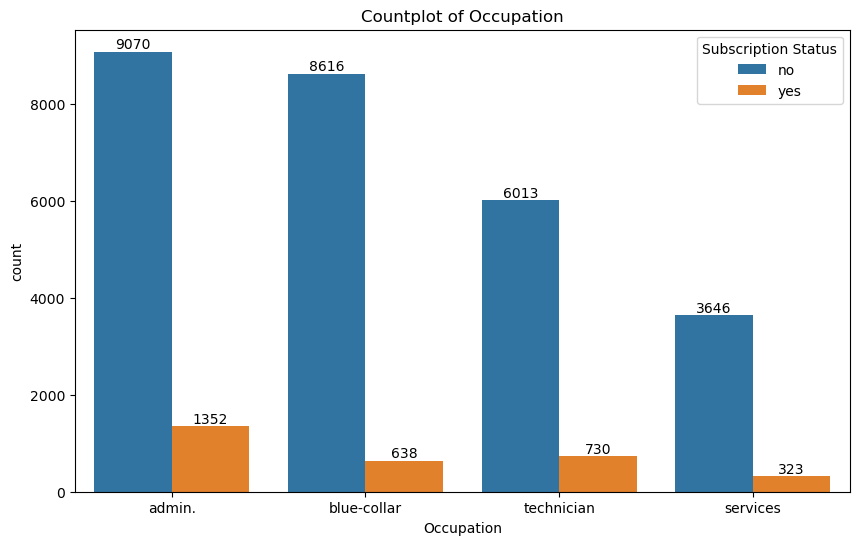

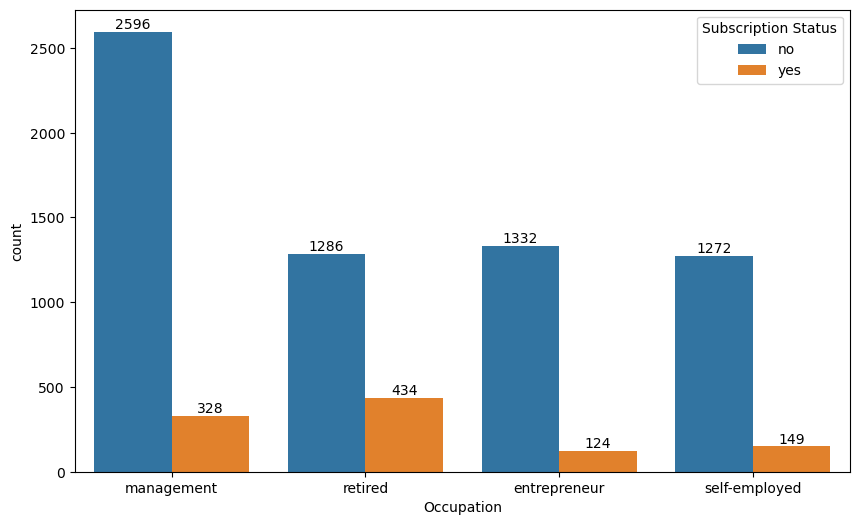

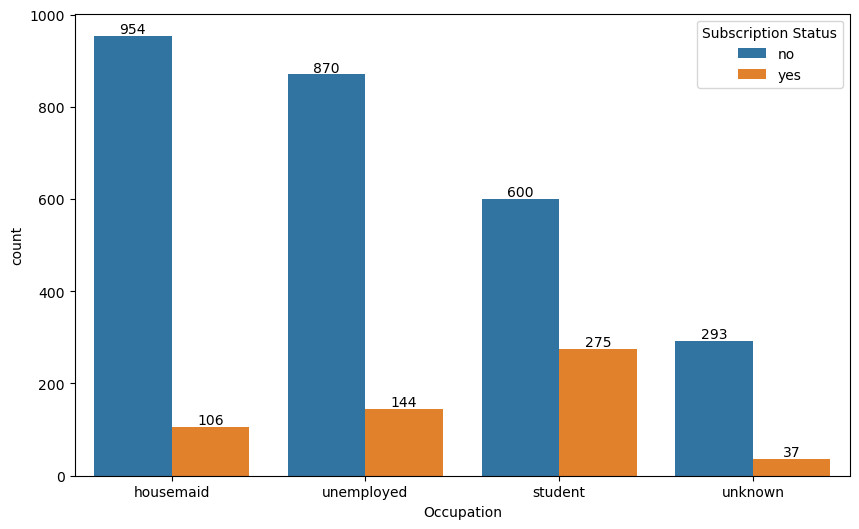

In [14]:
top_4 = df['Occupation'].value_counts().nlargest(4).index
df_top_4 = df[df['Occupation'].isin(top_4)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_top_4,x='Occupation',hue='Subscription Status',order=top_4)
plt.title('Countplot of Occupation')
annotate()

mid_4 = df['Occupation'].value_counts()[4:8].index
df_mid_4 = df[df['Occupation'].isin(mid_4)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_mid_4,x='Occupation',hue='Subscription Status',order=mid_4)
annotate()

last_4 = df['Occupation'].value_counts().nsmallest(4).index
df_last_4 = df[df['Occupation'].isin(last_4)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_last_4,x='Occupation',hue='Subscription Status',order=last_4[::-1])
annotate()

There are a total of 12 different occupations found in the data.
The most common occupations are admin, blue collar and technician representing 25%, 22% and 16% of the data respectively.
The least common occupations are unknown, student and unemployed representing 1%, 2% and 2% of the data respectively.

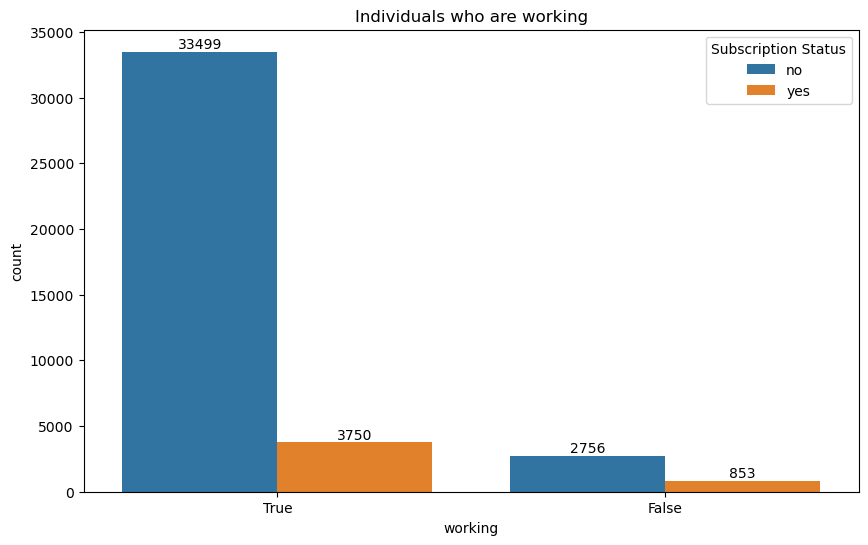

In [15]:
rows = df.loc[df['Occupation']=='unknown','Occupation'].index
df['working'] = (df['Occupation']!='unemployed') & (df['Occupation']!='retired') & (df['Occupation']!='student')
plt.figure(figsize=(10,6))
plt.title('Individuals who are working')
sns.countplot(data=df.drop(rows,axis=0),x='working',hue='Subscription Status',order=df['working'].value_counts().index)
annotate()

# Marital Status

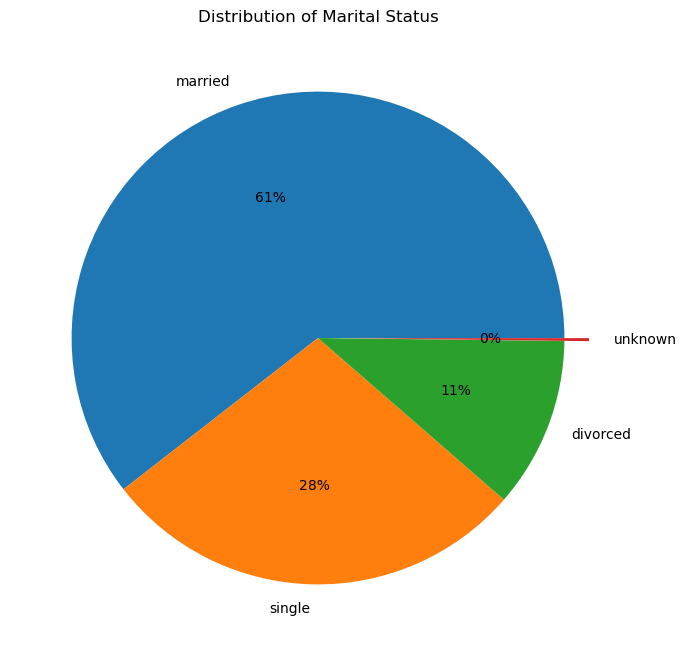

In [16]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Marital Status')
plt.pie(df['Marital Status'].value_counts().values,labels=df['Marital Status'].value_counts().index,autopct='%.0f%%',explode=(0,0,0,0.1))
plt.show()

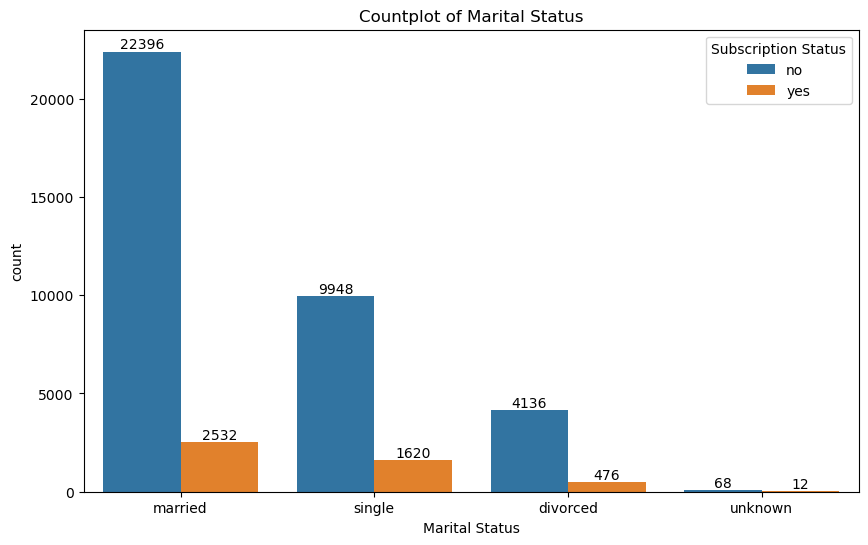

In [17]:
plt.figure(figsize=(10,6))
order = df['Marital Status'].value_counts().index
sns.countplot(data=df,x='Marital Status',hue='Subscription Status',order=order)
plt.title('Countplot of Marital Status')
annotate()

There are 4 categories of marital statuses.
Married individuals account for 61% of the data while unknown individuals account for close to 0%.

# Education Level

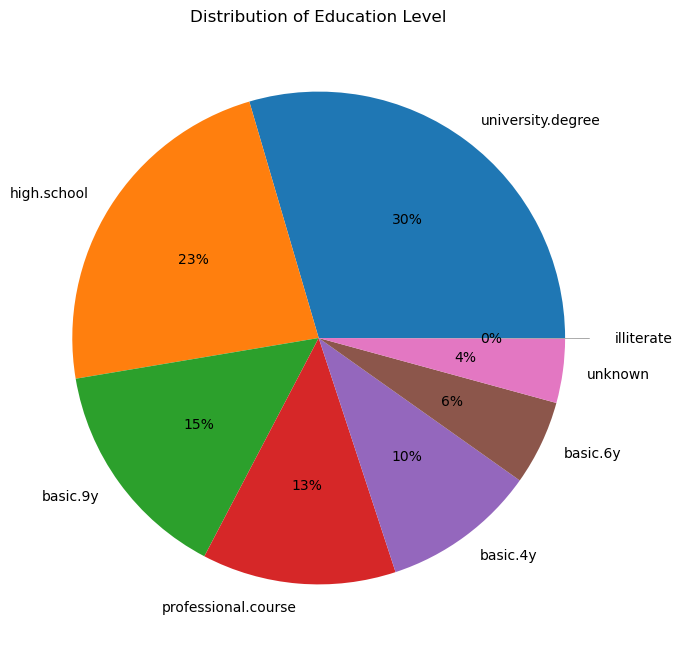

In [18]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Education Level')
plt.pie(df['Education Level'].value_counts().values,labels=df['Education Level'].value_counts().index,autopct='%.0f%%',explode=(0,0,0,0,0,0,0,.1))
plt.show()

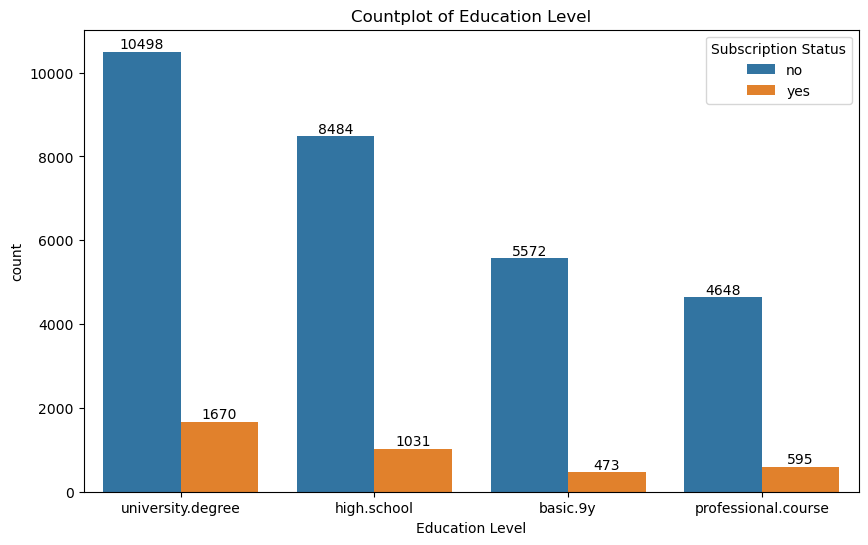

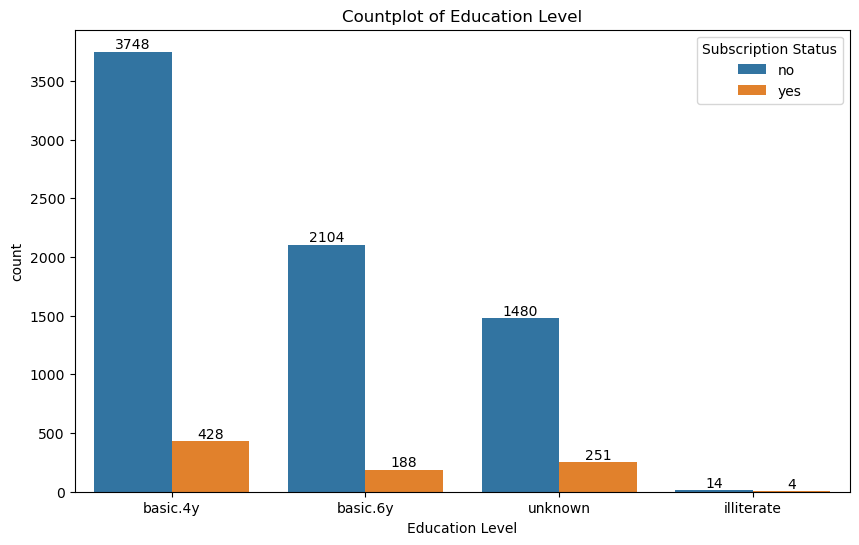

In [19]:
top_4 = df['Education Level'].value_counts().nlargest(4).index
df_top_4 = df[df['Education Level'].isin(top_4)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_top_4,x='Education Level',hue='Subscription Status',order=top_4)
plt.title('Countplot of Education Level')
annotate()

last_4 = df['Education Level'].value_counts().nsmallest(4).index
df_last_4 = df[df['Education Level'].isin(last_4)]

plt.figure(figsize=(10,6))
sns.countplot(data=df_last_4,x='Education Level',hue='Subscription Status',order=last_4[::-1])
plt.title('Countplot of Education Level')
annotate()

# Credit Default

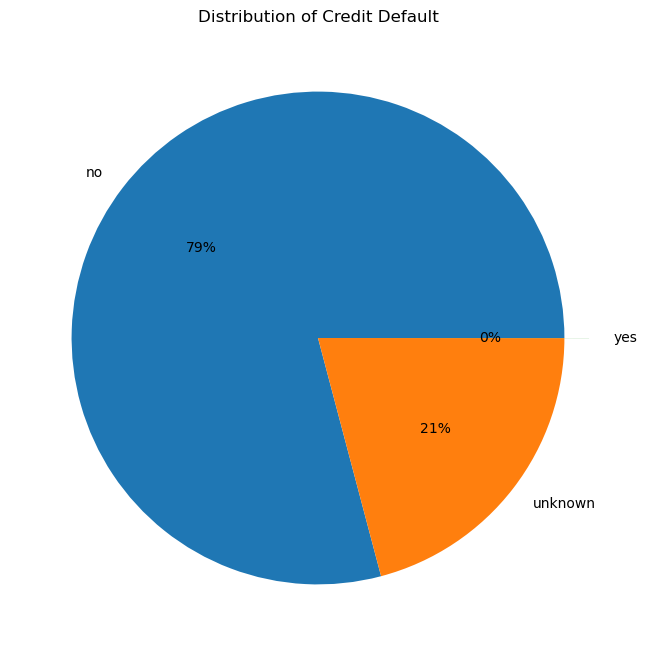

In [20]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Credit Default')
explode = (0,0,.1)
plt.pie(df['Credit Default'].value_counts().values,labels=df['Credit Default'].value_counts().index,autopct='%.0f%%',explode=explode)
plt.show()

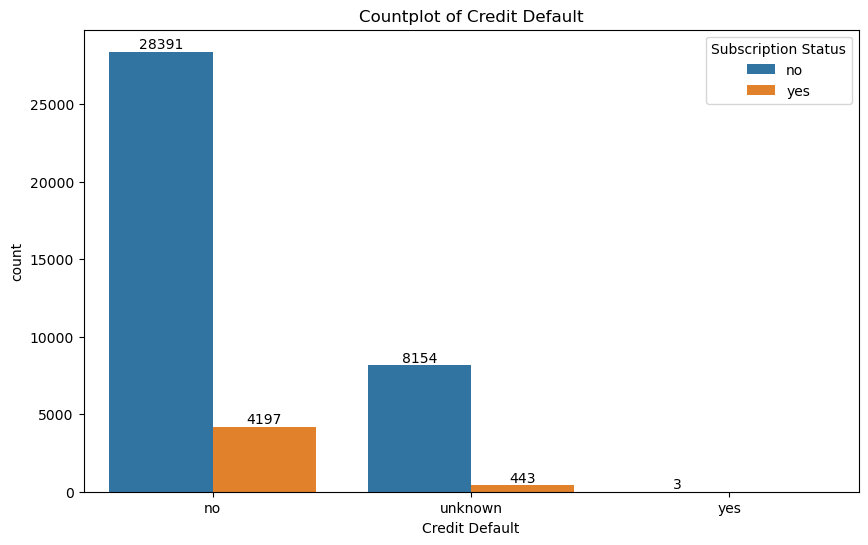

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Credit Default',hue='Subscription Status')
plt.title('Countplot of Credit Default')
annotate()

There are 3 cases of credit default.
79% of individuals did not default whereas 21% are unknown. 
There is a small minority who indicated they have defaulted.

# Housing Loan

In [22]:
print("Total number of null values in column: ",df['Housing Loan'].isnull().sum())
print(f"Percentage of null values in column: {df['Housing Loan'].isnull().sum()/df.shape[0]:.2f}%")

Total number of null values in column:  24789
Percentage of null values in column: 0.60%


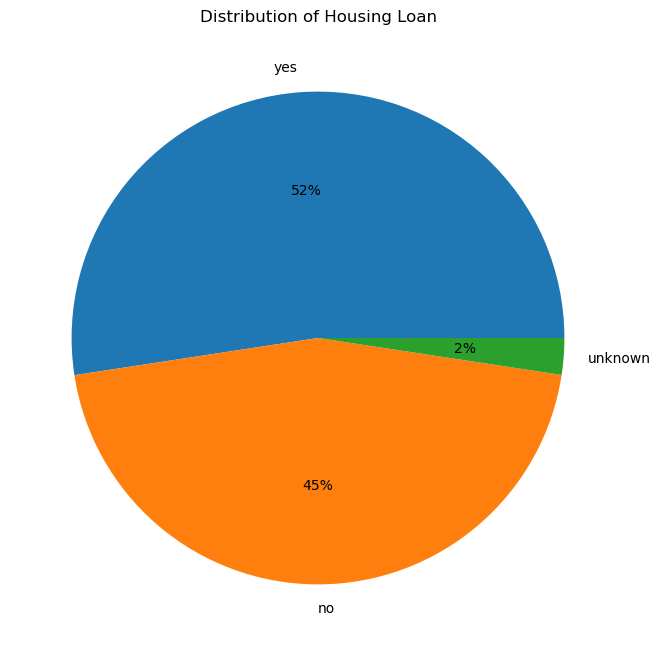

In [23]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Housing Loan')
plt.pie(df['Housing Loan'].value_counts().values,labels=df['Housing Loan'].value_counts().index,autopct='%.0f%%')
plt.show()

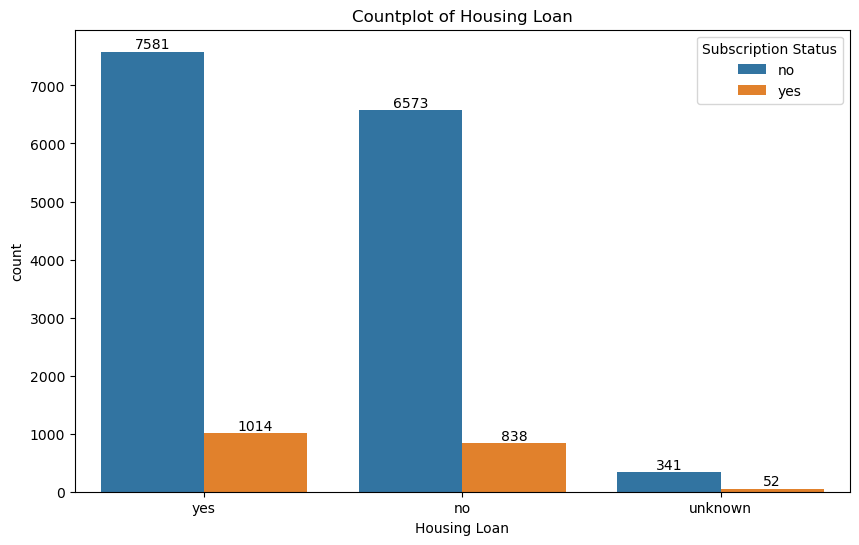

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Housing Loan',hue='Subscription Status',order=df['Housing Loan'].value_counts().index)
plt.title('Countplot of Housing Loan')
annotate()

The number of individuals have taken on a housing loan is only 1184 more than those who have not taken a housing loan. There is also a small minority of individuals who's housing loan status is unknown 

# Personal Loan

In [25]:
print("Total number of null values in column: ",df['Housing Loan'].isnull().sum())
print(f"Percentage of null values in column {df['Housing Loan'].isnull().sum()/df.shape[1]:.2f} %")

Total number of null values in column:  24789
Percentage of null values in column 2065.75 %


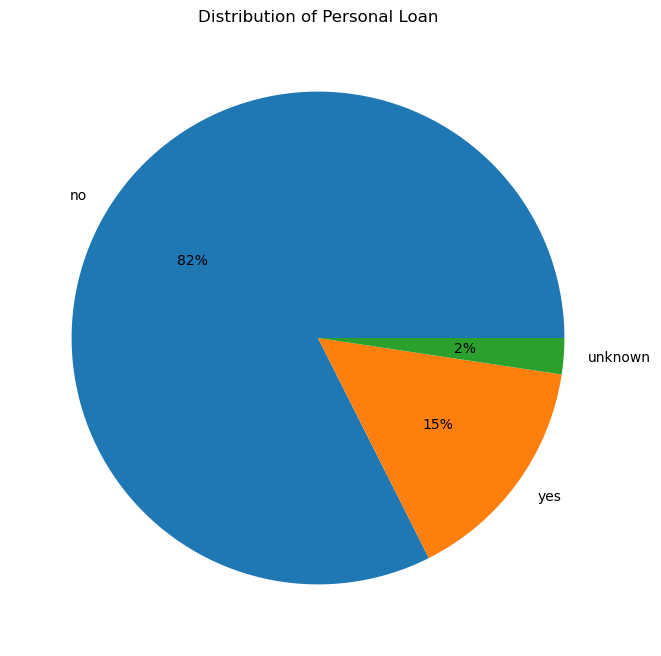

In [26]:
plt.figure(figsize=(8,8))
plt.title('Distribution of Personal Loan')
plt.pie(df['Personal Loan'].value_counts().values,labels=df['Personal Loan'].value_counts().index,autopct='%.0f%%')
plt.show()

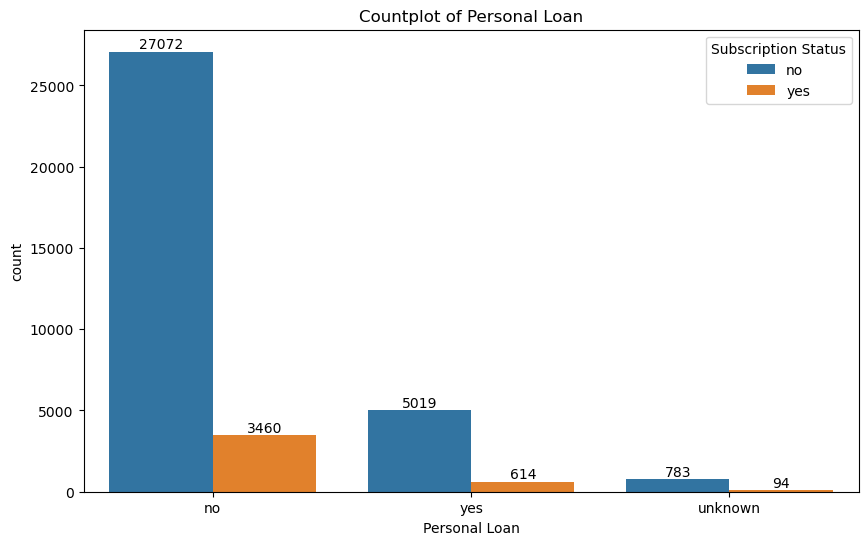

In [27]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Personal Loan',hue='Subscription Status',order=df['Personal Loan'].value_counts().index)
plt.title('Countplot of Personal Loan')
annotate()

Majority of individuals did not take personal loan.
There is again a small minority of individuals whose loan status is unknown.

# Contact Method

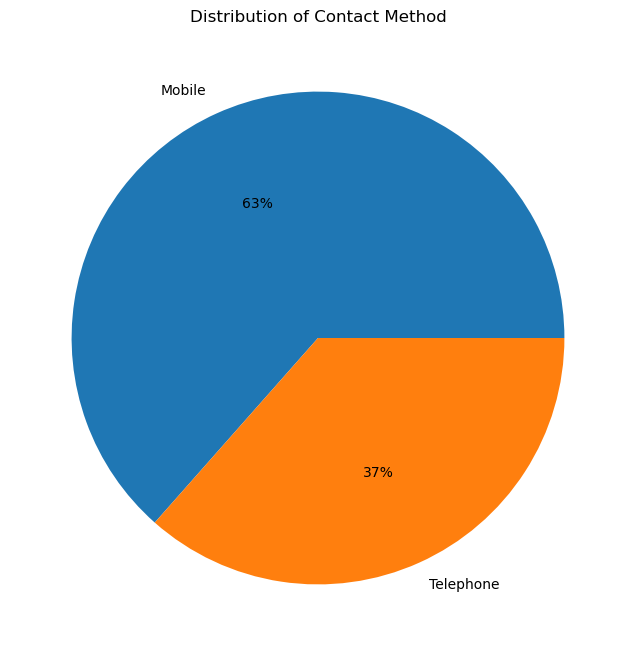

In [28]:
df['Contact Method'].replace({'telephone':'Telephone','cellular':'Mobile','Cell':'Mobile'},inplace=True)

plt.figure(figsize=(8,8))
plt.title('Distribution of Contact Method')
plt.pie(df['Contact Method'].value_counts().values,labels=df['Contact Method'].value_counts().index,autopct='%.0f%%')
plt.show()

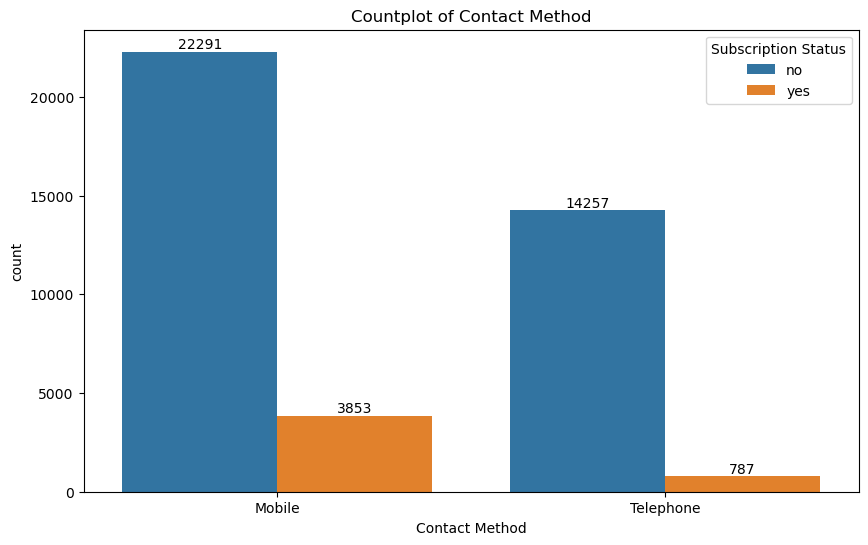

In [29]:
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='Contact Method',hue='Subscription Status',order=df['Contact Method'].value_counts().index)
plt.title('Countplot of Contact Method')
annotate()

There are only 2 contact methods.
Most people were contacted via mobile phone 

# Campaign Calls

[]

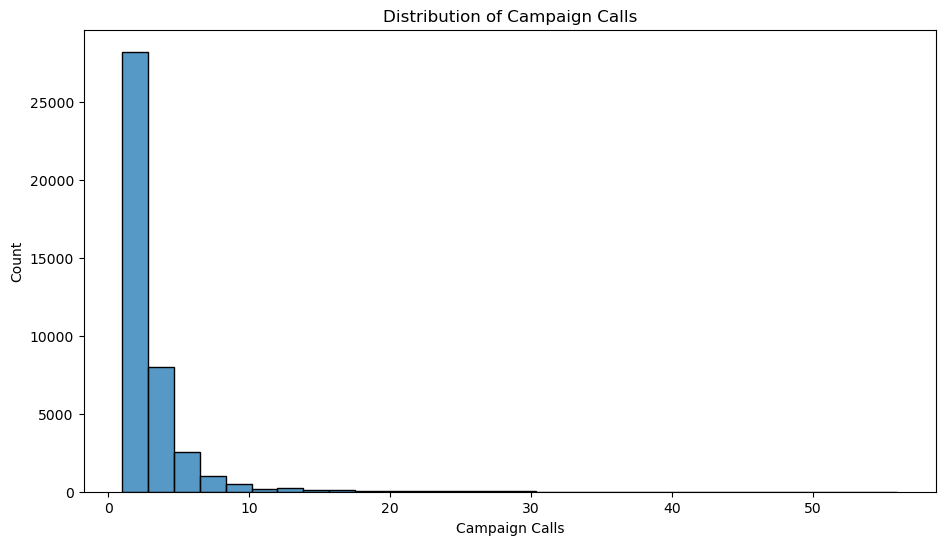

In [30]:
plt.figure(figsize=(11,6))
sns.histplot(data=df,x='Campaign Calls',bins=30)
plt.title('Distribution of Campaign Calls')
plt.plot()

Geometric distribution observed.
The number of individuals with campaign calls decreases exponentially as the number of campaign calls increases

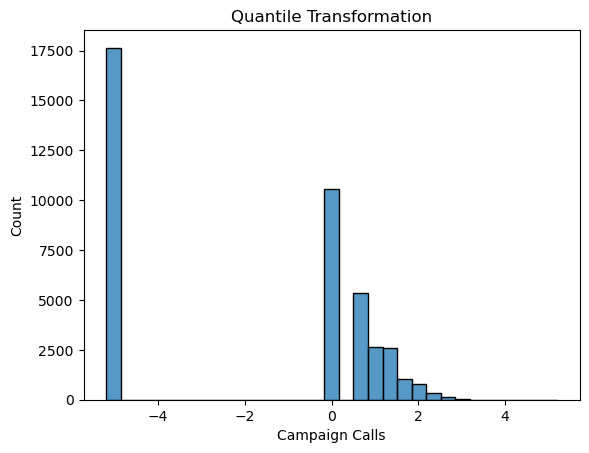

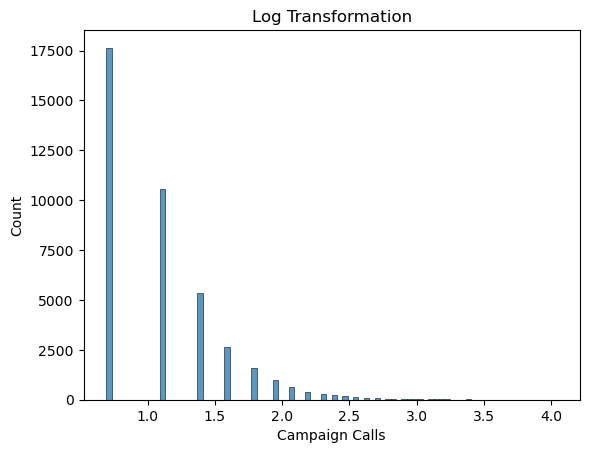

In [31]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution='normal')
df['quantile_trans'] = transformer.fit_transform(df[['Campaign Calls']])
sns.histplot(data=df,x='quantile_trans')
plt.title('Quantile Transformation')
plt.xlabel('Campaign Calls')
plt.show()

df['log_trans'] = np.log1p(df['Campaign Calls'])
plt.title('Log Transformation')
sns.histplot(data=df,x='log_trans')
plt.xlabel('Campaign Calls')
plt.show()

# Previous Contact Days

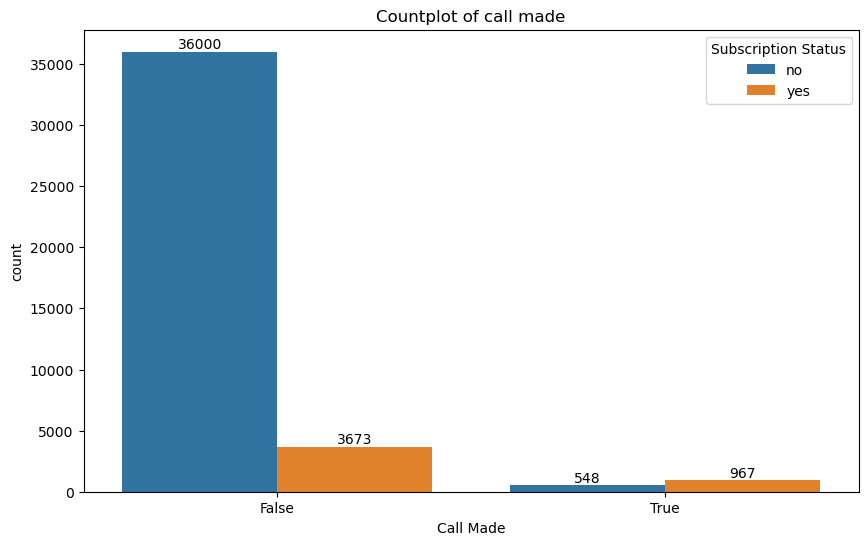

In [33]:
df['call_made'] = (df['Previous Contact Days']!=999) 
plt.figure(figsize=(10,6))
sns.countplot(data=df,x='call_made',hue='Subscription Status')
plt.title('Countplot of call made')
plt.xlabel('Call Made')
annotate()

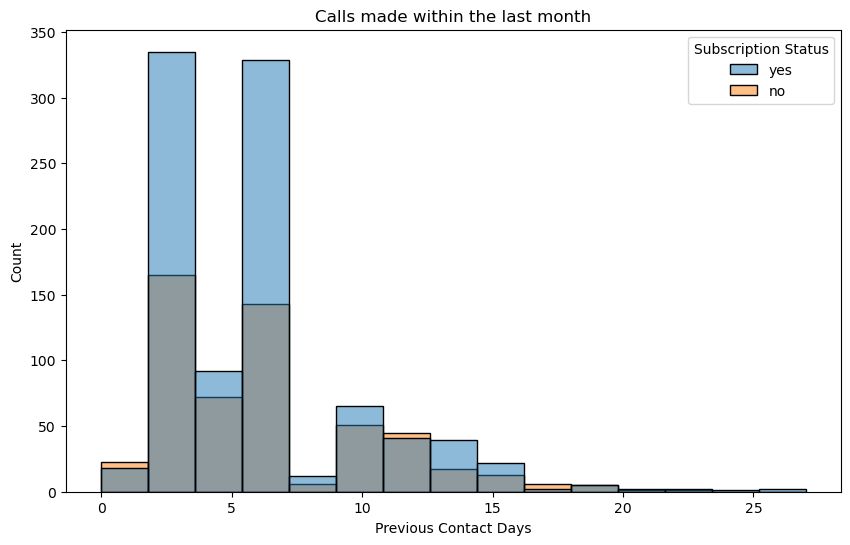

In [39]:
plt.figure(figsize=(10,6))
plt.title('Calls made within the last month')
sns.histplot(data=df[df['call_made']],x='Previous Contact Days',bins=15,hue='Subscription Status')
plt.show()

In [40]:
print("Count of no calls made:",sum(df['Previous Contact Days']==999))
print(f"Percentage of no calls made: {100*sum(df['Previous Contact Days']==999)/df.shape[0]:.0f}%")

Count of no calls made: 39673
Percentage of no calls made: 96%
